In [1]:
# Dataset : https://www.kaggle.com/datasets/niraliivaghani/flipkart-product-customer-reviews-dataset

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv(r"C:\Users\Prathamesh\Downloads\Projects\Flipkart Review Sentiment Analysis\Dataset-SA.csv")

In [4]:
df.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   205052 non-null  object
 1   product_price  205052 non-null  object
 2   Rate           205052 non-null  object
 3   Review         180388 non-null  object
 4   Summary        205041 non-null  object
 5   Sentiment      205052 non-null  object
dtypes: object(6)
memory usage: 9.4+ MB


In [6]:
df['Review'].unique()

array(['super!', 'awesome', 'fair', ..., 'good quality dinner set',
       'good quality product and good option for some one gift.',
       'product looking very nice & strong quality'], dtype=object)

In [7]:
df = df.dropna(subset=['Review'])

In [8]:
# Taking a random sample (20%) of the data for better visualization, cleaning and faster training
df1 = pd.read_csv(r"C:\Users\Prathamesh\Downloads\Projects\Flipkart Review Sentiment Analysis\Dataset-SA.csv").sample(frac = 0.2, random_state = 42)

In [9]:
df1.shape

(41010, 6)

In [10]:
df1["Sentiment"].value_counts()

Sentiment
positive    33420
negative     5557
neutral      2033
Name: count, dtype: int64

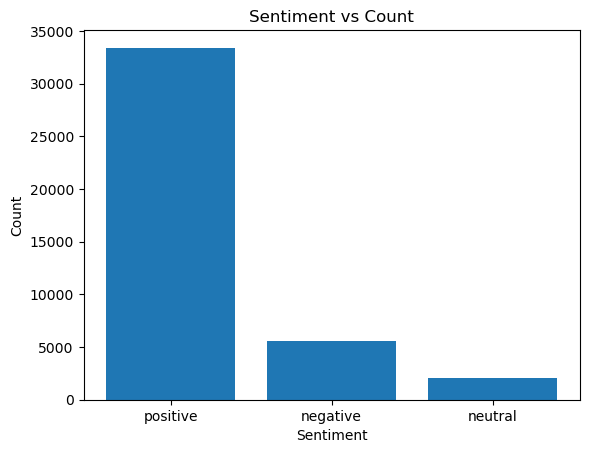

In [11]:
count = df1["Sentiment"].value_counts()
plt.bar(count.index, count.values)
plt.title("Sentiment vs Count")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [12]:
# There is a clear class imbalance

In [13]:
df1 = df1.dropna(subset=['Review'])

In [14]:
# Basic text cleaning
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@w+|\#','', text)  # remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuations
    text = re.sub(r'\d+', '', text)  # remove digits
    return text.strip()

df1['cleaned_review'] = df1['Review'].apply(clean_text)

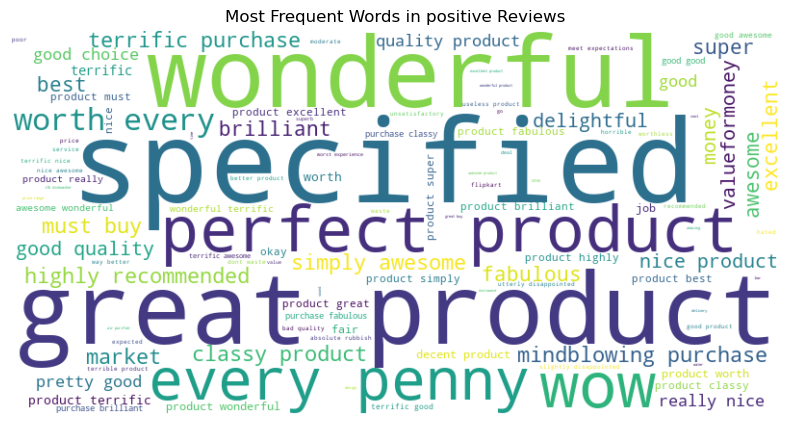

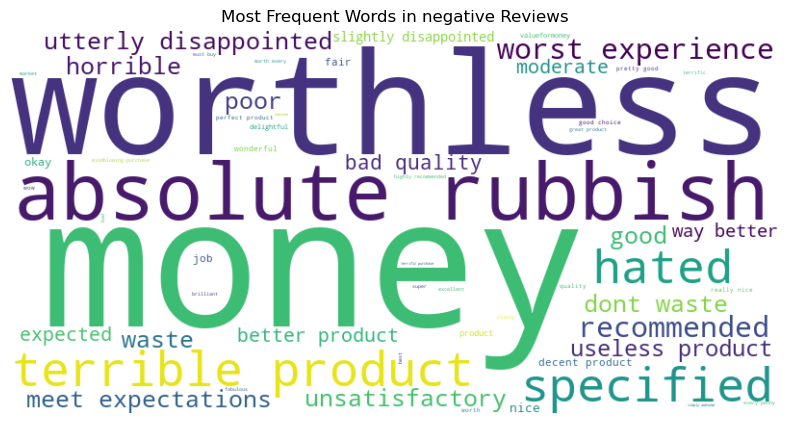

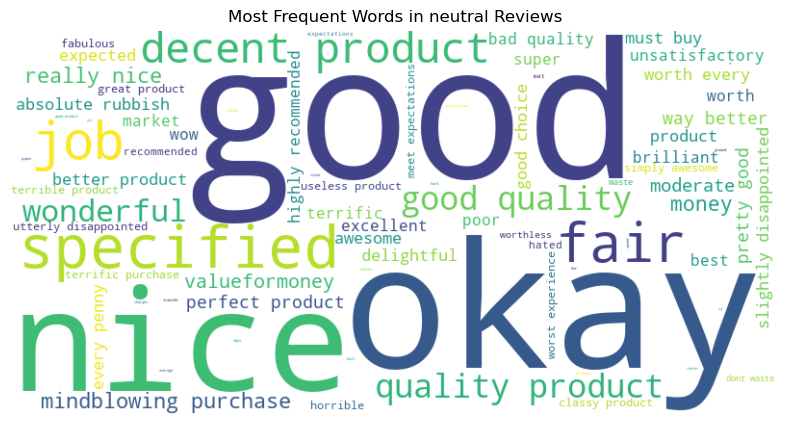

In [45]:
def generate_wordcloud(sentiment_label):
    text = " ".join(df1[df1['Sentiment'] == sentiment_label]['cleaned_review'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most Frequent Words in {sentiment_label} Reviews")
    plt.show()

generate_wordcloud('positive')
generate_wordcloud('negative')
generate_wordcloud('neutral')

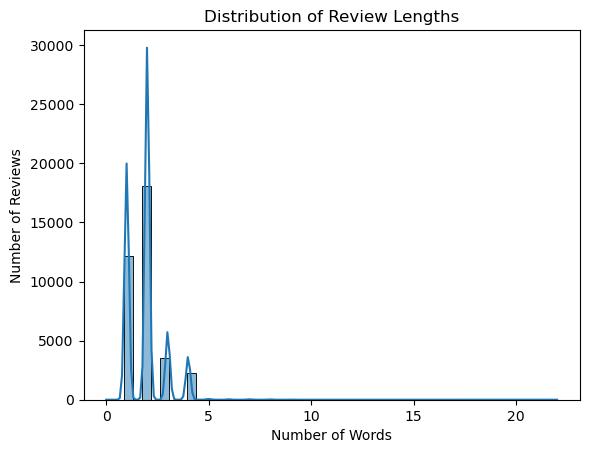

In [46]:
df1['review_length'] = df1['cleaned_review'].apply(lambda x: len(str(x).split()))
sns.histplot(data=df1, x='review_length', bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

In [15]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))  # unigrams + bigrams
X = vectorizer.fit_transform(df1['cleaned_review'])

In [16]:
y = df1['Sentiment']

In [17]:
# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [19]:
# Model training (Logistic Regression)
model = LogisticRegression(class_weight=class_weight_dict, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(class_weight={'negative': 2.499350480644323,
                                 'neutral': 6.896057347670251,
                                 'positive': 0.4073509485094851},
                   max_iter=1000)

In [20]:
y_pred = model.predict(X_test)

In [21]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

    negative       0.84      0.80      0.82       962
     neutral       0.11      0.38      0.18       349
    positive       0.97      0.84      0.90      5904

    accuracy                           0.81      7215
   macro avg       0.64      0.67      0.63      7215
weighted avg       0.91      0.81      0.85      7215

Confusion Matrix:

[[ 766  150   46]
 [  85  134  130]
 [  64  895 4945]]


In [22]:
# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [23]:
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [24]:
# Model Training (Random Forest)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=50,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train_encoded)

RandomForestClassifier(class_weight='balanced', max_depth=50, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [25]:
# Predict
y_pred_encoded = rf_model.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)
y_test_str = le.inverse_transform(y_test_encoded)

In [26]:
# Evaluation
print("Classification Report:\n")
print(classification_report(y_test_str, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test_str, y_pred))

Classification Report:

              precision    recall  f1-score   support

    negative       0.84      0.79      0.82       962
     neutral       0.12      0.38      0.18       349
    positive       0.97      0.84      0.90      5904

    accuracy                           0.81      7215
   macro avg       0.64      0.67      0.63      7215
weighted avg       0.91      0.81      0.85      7215

Confusion Matrix:

[[ 764  149   49]
 [  85  133  131]
 [  57  871 4976]]


In [27]:
# In both the models the "Neutral" class is doing pretty bad.

In [28]:
# Combining Reviews and Summary
df1['combined_text'] = df1['cleaned_review'].fillna('') + ' ' + df1['Summary'].fillna('')

In [29]:
import re

def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

df1['cleaned_summary'] = df1['Summary'].fillna('').apply(clean_text)
df1['combined_text'] = df1['cleaned_review'].fillna('') + ' ' + df1['cleaned_summary']

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words='english',
    sublinear_tf=True       # scales down overly common words.
)

X = tfidf.fit_transform(df1['combined_text'])
y = df1['Sentiment']

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=50,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Decode back
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred)

print("Classification Report:\n")
print(classification_report(y_test_str, y_pred_str))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test_str, y_pred_str))

Classification Report:

              precision    recall  f1-score   support

    negative       0.85      0.84      0.84       962
     neutral       0.36      0.50      0.42       349
    positive       0.97      0.95      0.96      5904

    accuracy                           0.91      7215
   macro avg       0.73      0.76      0.74      7215
weighted avg       0.92      0.91      0.92      7215

Confusion Matrix:

[[ 804   93   65]
 [  70  173  106]
 [  76  213 5615]]


In [33]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear',
    random_state=42
)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Decode labels
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred)

print("Classification Report:\n")
print(classification_report(y_test_str, y_pred_str))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test_str, y_pred_str))


Classification Report:

              precision    recall  f1-score   support

    negative       0.85      0.85      0.85       962
     neutral       0.54      0.48      0.51       349
    positive       0.97      0.97      0.97      5904

    accuracy                           0.93      7215
   macro avg       0.78      0.77      0.78      7215
weighted avg       0.93      0.93      0.93      7215

Confusion Matrix:

[[ 821   47   94]
 [  70  166  113]
 [  76   94 5734]]


In [34]:
# Step 1: Your test sentence
test_review = ["I am not impressed with this product. It's average at best."]

# Step 2: Transform it using the same TF-IDF vectorizer
test_tfidf = tfidf.transform(test_review)

# Step 3: Predict sentiment
predicted_class_encoded = log_reg.predict(test_tfidf)
predicted_sentiment = le.inverse_transform(predicted_class_encoded)

print("Predicted Sentiment:", predicted_sentiment[0])

Predicted Sentiment: neutral


In [40]:
# Step 1: Your test sentence
test_review = ["I'm not sure about this product. Kinda works okay I guess"]

# Step 2: Transform it using the same TF-IDF vectorizer
test_tfidf = tfidf.transform(test_review)

# Step 3: Predict sentiment
predicted_class_encoded = log_reg.predict(test_tfidf)
predicted_sentiment = le.inverse_transform(predicted_class_encoded)

print("Predicted Sentiment:", predicted_sentiment[0])

Predicted Sentiment: neutral


In [47]:
import joblib

# Save vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# Save model
joblib.dump(log_reg, 'sentiment_model.pkl')

['sentiment_model.pkl']

In [48]:
# Load vectorizer and model
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')
loaded_model = joblib.load('sentiment_model.pkl')